In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import torch
import scanpy as sc
import umap
import cv2


d:\Fall 2024\manaswini capstone\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scanpy as sc

# Load the dataset
# Replace 'TM_data.csv' with the actual path to your dataset
data_path = "TM_data.csv"
data = pd.read_csv(data_path, index_col=0)

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("Preview of Dataset:")
print(data.head())

# Normalize the dataset (log-transform if necessary)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)

# Convert back to DataFrame for easy handling
data_normalized = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)

print("\nDataset after normalization:")
print(data_normalized.head())


Dataset Shape: (54864, 1088)
Preview of Dataset:
   0.1  0.2  0.3  0.4  0.5  203  0.6  0.7  0.8  0.9  ...  0.440  1.124  1.125  \
0                                                    ...                        
0    0    0    0    0    0  339    0    0    0    0  ...      3      2      2   
0    0    0    0    0    0  255    0    0    0    0  ...      0      2      0   
0    0    0    2    0    0  155    0    0    0    0  ...      0      3      1   
0    1    0    0    0    0  543    0    0    0    0  ...      1      4      8   
0    0    0    0    0    0  184    0    0    1    0  ...      4      5      2   

   0.441  0.442  0.443  1.126  1.127  0.444  2.95  
0                                                  
0      0      0      0      0      2      6     1  
0      0      0      0      2      4      0     0  
0      0      0      0      2      0      1     0  
0      0      0      0      2      3      1     1  
0      0      9      0      3     10      0     0  

[5 rows x 1088 col

In [3]:
# Calculate covariance matrix
covariance_matrix = np.cov(data_normalized.values.T)

# Compute interaction strength matrix (inverse of covariance matrix)
interaction_matrix = np.linalg.pinv(covariance_matrix)  # Use pseudo-inverse for stability

# Scale interaction matrix to [0, 2]
interaction_matrix_scaled = (interaction_matrix - interaction_matrix.min()) / (
    interaction_matrix.max() - interaction_matrix.min()
) * 2

print("\nInteraction Matrix Shape:", interaction_matrix_scaled.shape)



Interaction Matrix Shape: (1088, 1088)



Number of Genomaps Created: 54864
Genomap Shape: (33, 33)


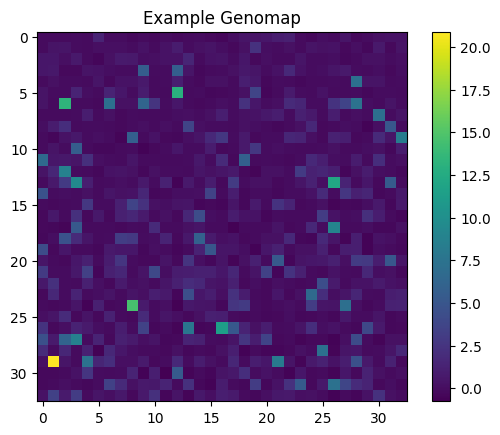

In [4]:
import cv2

# Set grid size for genomap (assume square grid)
n_genes = data_normalized.shape[1]
grid_size = int(np.ceil(np.sqrt(n_genes)))  # Determine grid dimensions

# Create genomaps for each cell
genomaps = []
for idx, cell in enumerate(data_normalized.values):
    # Reshape gene values into 2D grid
    genomap = np.zeros((grid_size, grid_size))
    values = cell[:grid_size**2]  # Use only the first grid_size^2 genes
    genomap.flat[: len(values)] = values  # Fill the 2D grid with gene values
    genomaps.append(genomap)

# Convert to numpy array
genomaps = np.array(genomaps)

print("\nNumber of Genomaps Created:", len(genomaps))
print("Genomap Shape:", genomaps[0].shape)

# Visualize an example genomap
plt.imshow(genomaps[0], cmap="viridis")
plt.colorbar()
plt.title("Example Genomap")
plt.show()


In [5]:
np.save("genomaps.npy", genomaps)
print("Genomaps saved as 'genomaps.npy'")


Genomaps saved as 'genomaps.npy'


Shape of loaded genomaps: (54864, 33, 33)
Example Genomap:


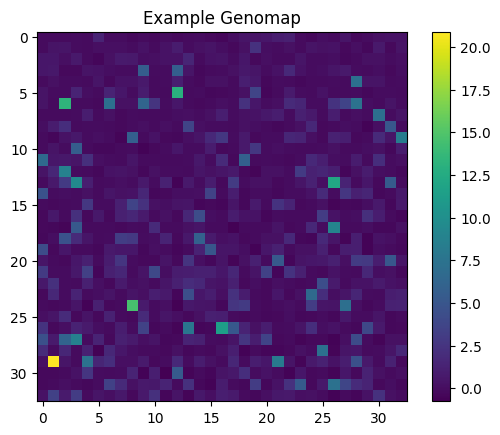

In [6]:
# Load the saved genomaps
loaded_genomaps = np.load("genomaps.npy")

# Check shape and content
print("Shape of loaded genomaps:", loaded_genomaps.shape)
print("Example Genomap:")
plt.imshow(loaded_genomaps[0], cmap="viridis")
plt.colorbar()
plt.title("Example Genomap")
plt.show()


In [7]:
# Flatten the genomaps for feature extraction
genomaps_flattened = genomaps.reshape(genomaps.shape[0], -1)

print("Shape of flattened genomaps:", genomaps_flattened.shape)


Shape of flattened genomaps: (54864, 1089)


d:\Fall 2024\manaswini capstone\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of reduced embeddings: (54864, 2)


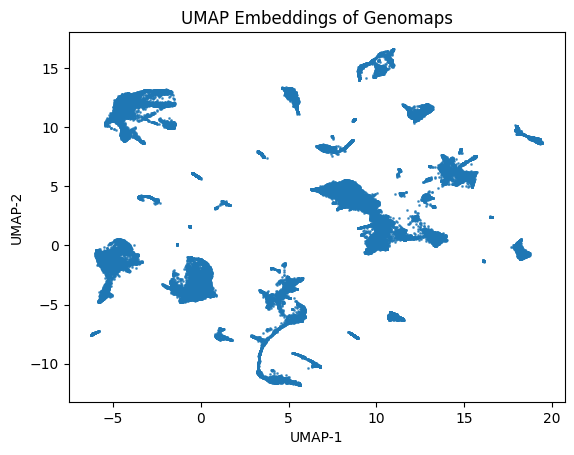

In [8]:
import umap

# Reduce dimensions to 2 for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
genomap_embeddings = umap_reducer.fit_transform(genomaps_flattened)

print("Shape of reduced embeddings:", genomap_embeddings.shape)

# Plot the embeddings
plt.scatter(genomap_embeddings[:, 0], genomap_embeddings[:, 1], s=1, alpha=0.7)
plt.title("UMAP Embeddings of Genomaps")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


Clusters assigned to each genomap: [0 1 2 3 4 5 6 7 8 9]


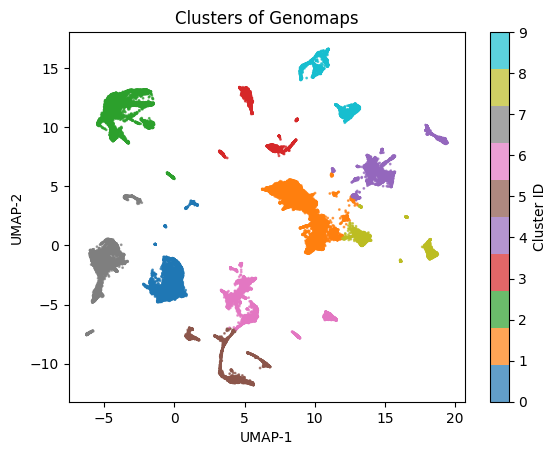

In [9]:
from sklearn.cluster import KMeans

# Define the number of clusters (choose based on data size and variability)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(genomap_embeddings)

print("Clusters assigned to each genomap:", np.unique(clusters))

# Plot the clusters
plt.scatter(genomap_embeddings[:, 0], genomap_embeddings[:, 1], c=clusters, cmap="tab10", s=1, alpha=0.7)
plt.title("Clusters of Genomaps")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.show()


In [10]:
# Save the cluster assignments
cluster_assignments = pd.DataFrame({
    "Cell_Index": np.arange(len(clusters)),
    "Cluster_ID": clusters
})
cluster_assignments.to_csv("genomap_clusters.csv", index=False)

print("Cluster assignments saved to 'genomap_clusters.csv'")


Cluster assignments saved to 'genomap_clusters.csv'


Cluster Sizes:
1    10868
0     8937
2     7883
7     6967
4     4796
6     4267
8     3147
9     2983
3     2614
5     2402
Name: count, dtype: int64


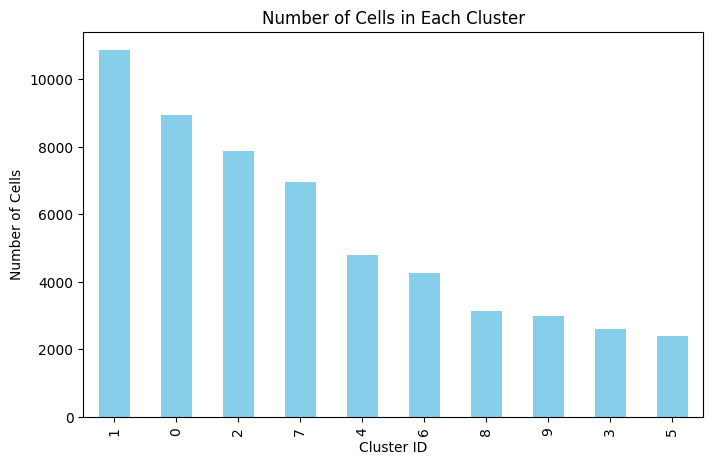

In [11]:
# Analyze cluster sizes
cluster_sizes = pd.Series(clusters).value_counts()

print("Cluster Sizes:")
print(cluster_sizes)

# Visualize cluster sizes
cluster_sizes.plot(kind="bar", color="skyblue", figsize=(8, 5))
plt.title("Number of Cells in Each Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Cells")
plt.show()



Examples from Cluster 0:


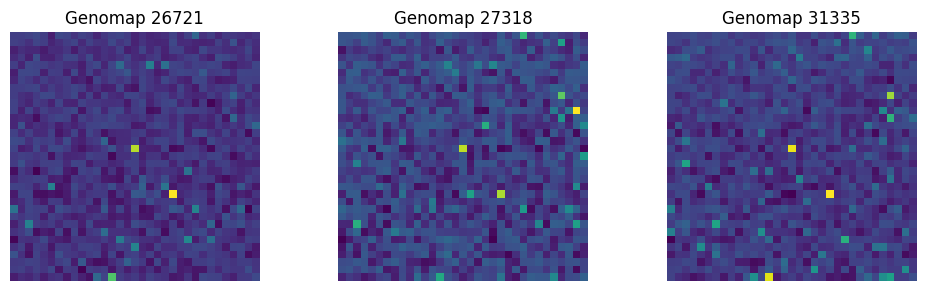


Examples from Cluster 1:


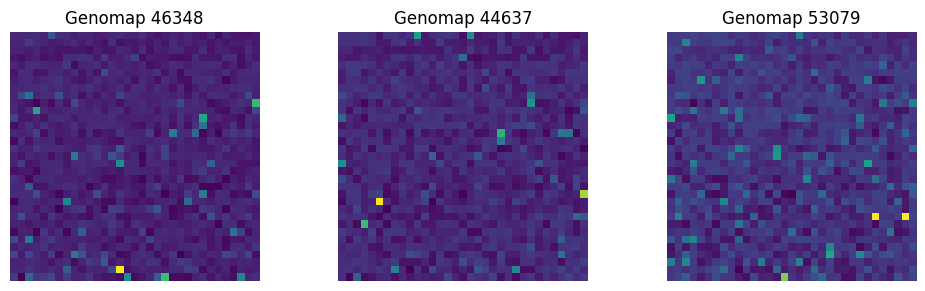


Examples from Cluster 2:


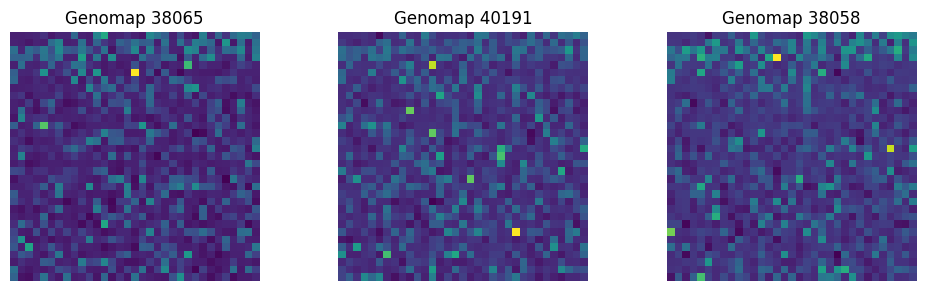


Examples from Cluster 3:


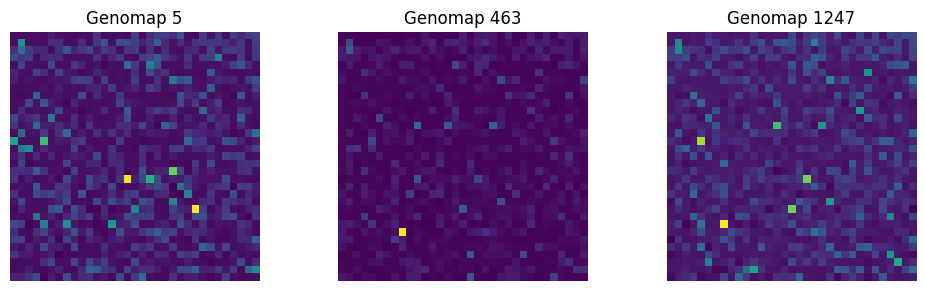


Examples from Cluster 4:


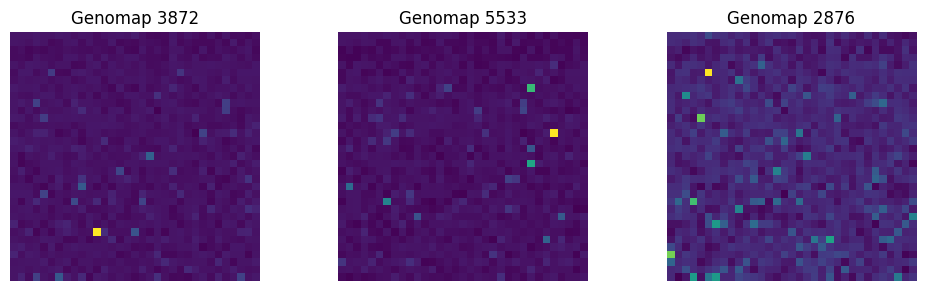


Examples from Cluster 5:


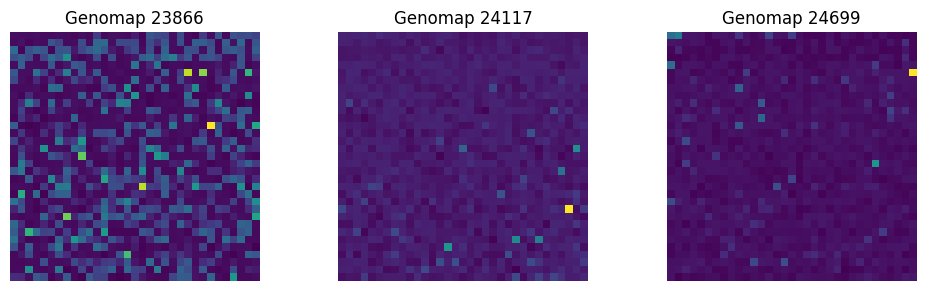


Examples from Cluster 6:


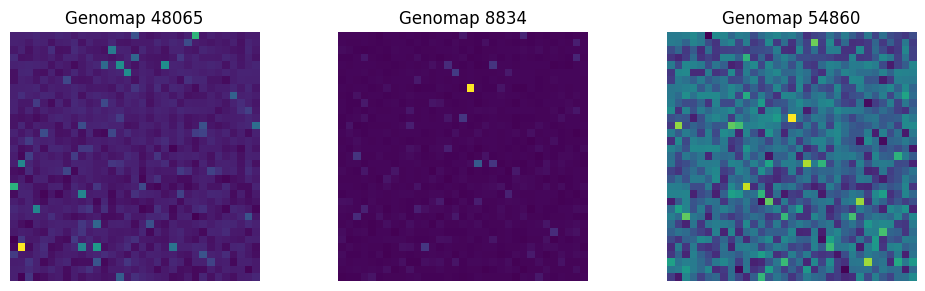


Examples from Cluster 7:


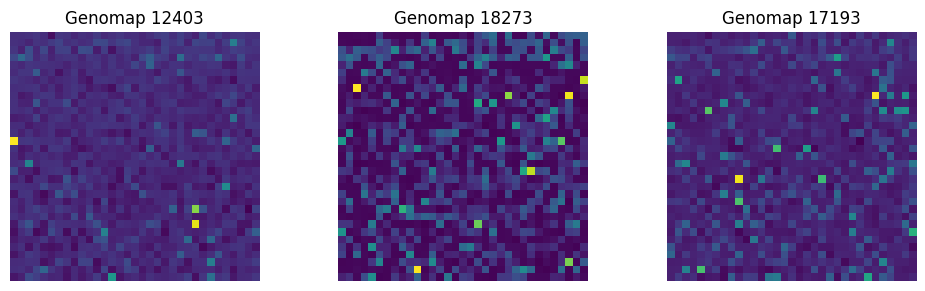


Examples from Cluster 8:


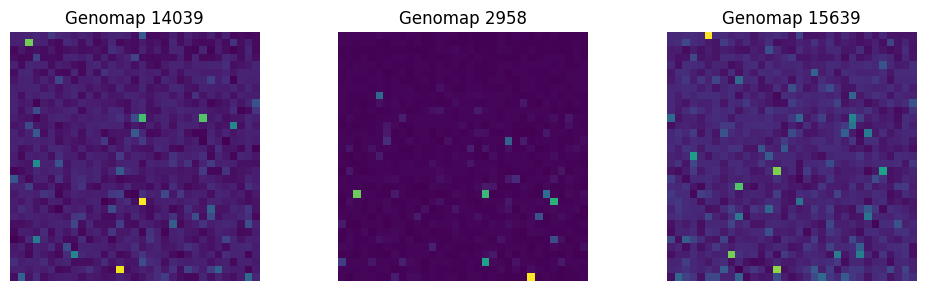


Examples from Cluster 9:


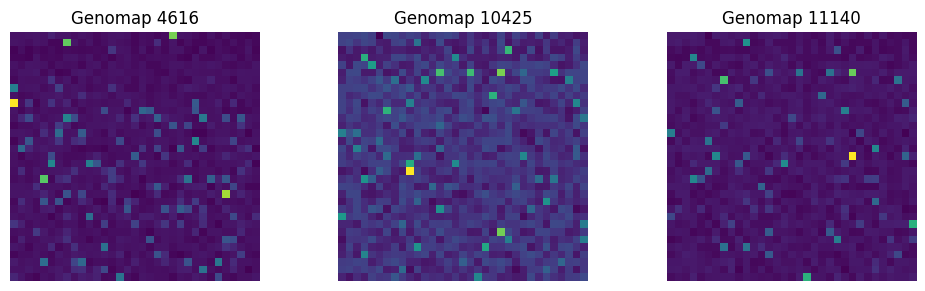

In [12]:
# Select a few genomaps from each cluster
examples_per_cluster = 3
for cluster_id in np.unique(clusters):
    print(f"\nExamples from Cluster {cluster_id}:")
    cluster_indices = np.where(clusters == cluster_id)[0]
    selected_indices = np.random.choice(cluster_indices, min(len(cluster_indices), examples_per_cluster), replace=False)
    
    # Plot selected genomaps
    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, examples_per_cluster, i + 1)
        plt.imshow(genomaps[idx], cmap="viridis")
        plt.title(f"Genomap {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [13]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(genomap_embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f} (Higher is better, max = 1)")


Silhouette Score: 0.58 (Higher is better, max = 1)


In [14]:
# Map cells to clusters and calculate average expression
data_with_clusters = data_normalized.copy()
data_with_clusters["Cluster_ID"] = clusters

# Compute mean expression per cluster
cluster_means = data_with_clusters.groupby("Cluster_ID").mean()
print("\nMean Gene Expression Per Cluster:")
print(cluster_means.head())

# Save cluster means to file for further analysis
cluster_means.to_csv("cluster_mean_expression.csv")
print("Cluster mean expressions saved to 'cluster_mean_expression.csv'")



Mean Gene Expression Per Cluster:
                 0.1       0.2       0.3       0.4       0.5       203  \
Cluster_ID                                                               
0          -0.134598 -0.132510 -0.097086 -0.017044 -0.161032 -0.198880   
1          -0.135600 -0.133775 -0.097060 -0.010781 -0.161032  0.229721   
2          -0.135612 -0.133905  0.573839 -0.017266  0.959617 -0.315400   
3          -0.135403 -0.133536 -0.084071  0.297461 -0.161011  0.689890   
4          -0.135038 -0.133286 -0.097077 -0.015019 -0.161036  0.106288   

                 0.6       0.7       0.8       0.9  ...     0.440     1.124  \
Cluster_ID                                          ...                       
0          -0.013595 -0.056107 -0.283105 -0.110078  ... -0.277445 -0.247920   
1          -0.004948 -0.056038 -0.283026 -0.110889  ... -0.395666 -0.391135   
2          -0.014271  0.334243  1.682700 -0.110836  ...  1.266326  0.985882   
3           0.241492 -0.056019 -0.282683 -0.110849 

d:\Fall 2024\manaswini capstone\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


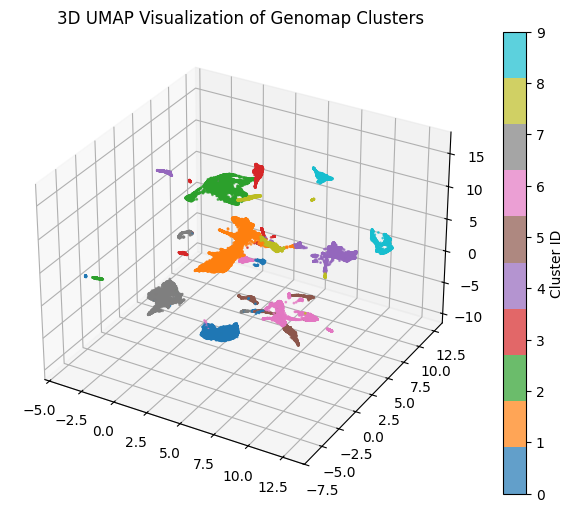

In [15]:
# 3D UMAP reduction
umap_3d = umap.UMAP(n_components=3, random_state=42)
genomap_embeddings_3d = umap_3d.fit_transform(genomaps_flattened)

# Plot 3D clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(genomap_embeddings_3d[:, 0], genomap_embeddings_3d[:, 1], genomap_embeddings_3d[:, 2], 
                c=clusters, cmap="tab10", s=1, alpha=0.7)
plt.colorbar(sc, label="Cluster ID")
plt.title("3D UMAP Visualization of Genomap Clusters")
plt.show()


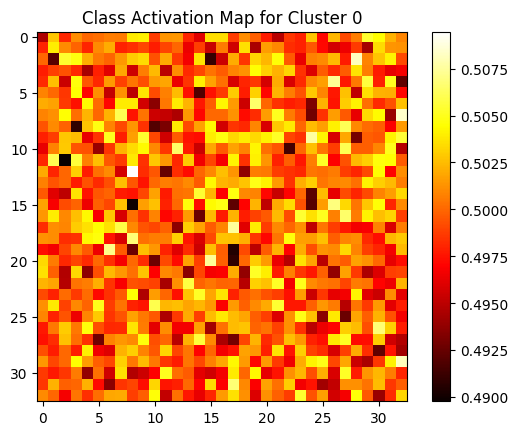

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_activation_maps(cluster_id, genomaps, clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    # Assume we have Grad-CAM values for each genomap
    grad_cam_values = np.random.random((len(cluster_indices), genomaps[0].shape[0], genomaps[0].shape[1]))  # Placeholder
    avg_grad_cam = np.mean(grad_cam_values, axis=0)

    plt.imshow(avg_grad_cam, cmap='hot')
    plt.title(f"Class Activation Map for Cluster {cluster_id}")
    plt.colorbar()
    plt.show()

# Example: Plot for cluster 0
plot_class_activation_maps(0, genomaps, clusters)


In [17]:
print("Columns in the dataset:")
print(data_with_clusters.columns)


Columns in the dataset:
Index(['0.1', '0.2', '0.3', '0.4', '0.5', '203', '0.6', '0.7', '0.8', '0.9',
       ...
       '1.124', '1.125', '0.441', '0.442', '0.443', '1.126', '1.127', '0.444',
       '2.95', 'Cluster_ID'],
      dtype='object', length=1089)


In [18]:
# Compute mean values for each cluster
cluster_means = data_with_clusters.groupby("Cluster_ID").mean()

# Display top features for each cluster
top_features_per_cluster = cluster_means.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
print("Top features for each cluster:")
print(top_features_per_cluster)


Top features for each cluster:
Cluster_ID
0        [0.201, 0.280, 0.435, 0.359, 3]
1         [36.2, 17.3, 0.172, 0.285, 16]
2          [9.1, 2.19, 5.2, 21.3, 0.425]
3         [1.5, 1.69, 16.1, 0.179, 3.15]
4      [4.20, 1.122, 0.57, 0.342, 0.438]
5         [0.1, 0.2, 0.90, 0.153, 0.238]
6    [0.247, 0.157, 0.119, 0.408, 0.349]
7      [0.417, 2.60, 0.183, 1.98, 0.442]
8            [5.6, 0.383, 13.3, 124, 87]
9      [0.150, 1.55, 0.253, 1.62, 0.262]
dtype: object



Cluster 0:


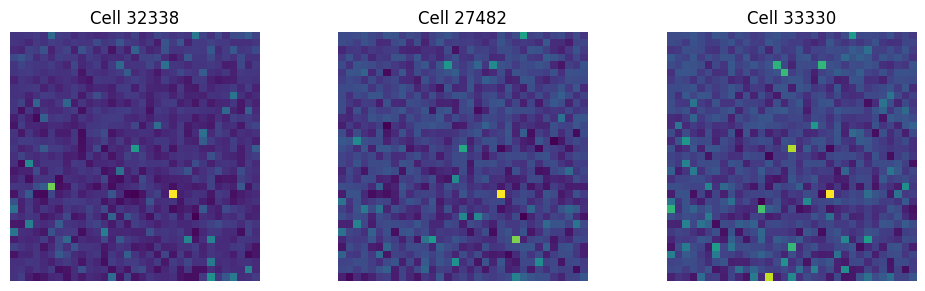


Cluster 1:


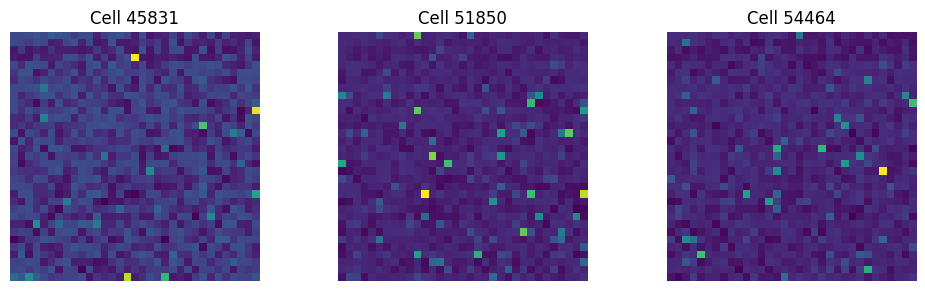


Cluster 2:


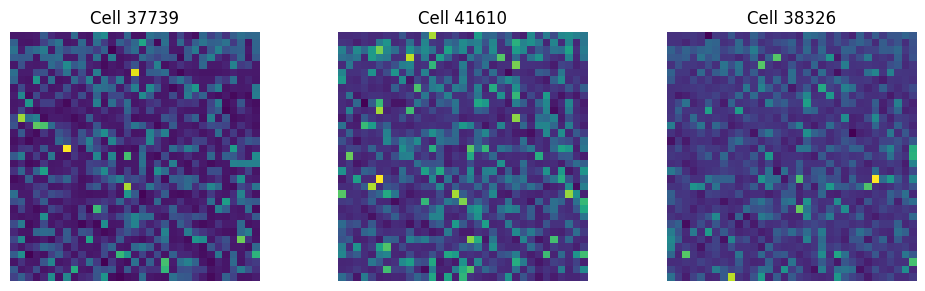


Cluster 3:


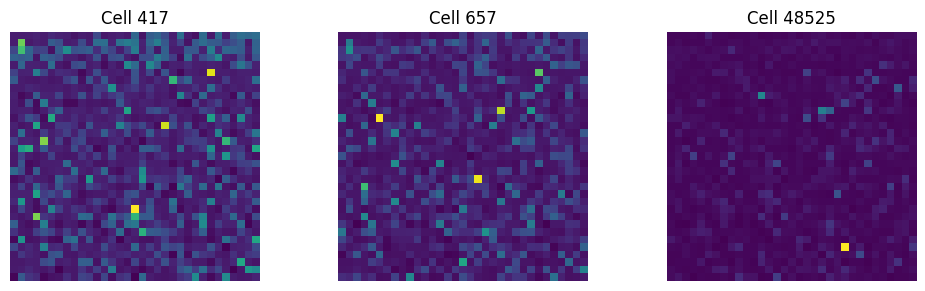


Cluster 4:


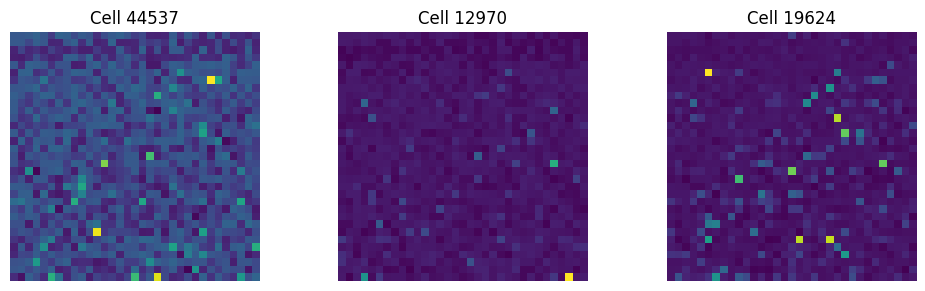


Cluster 5:


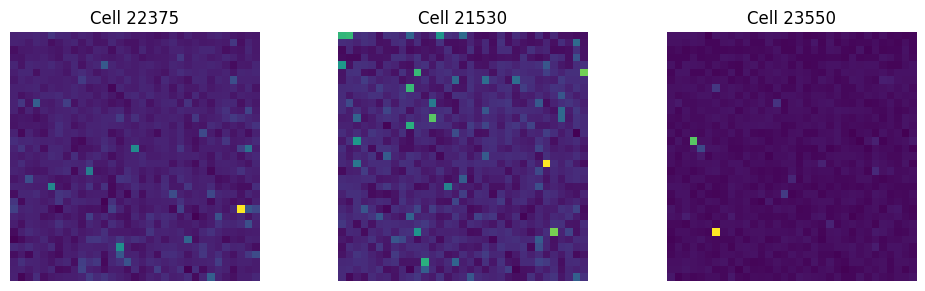


Cluster 6:


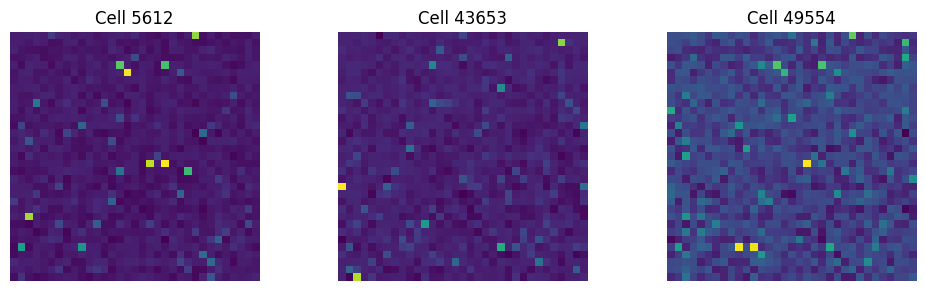


Cluster 7:


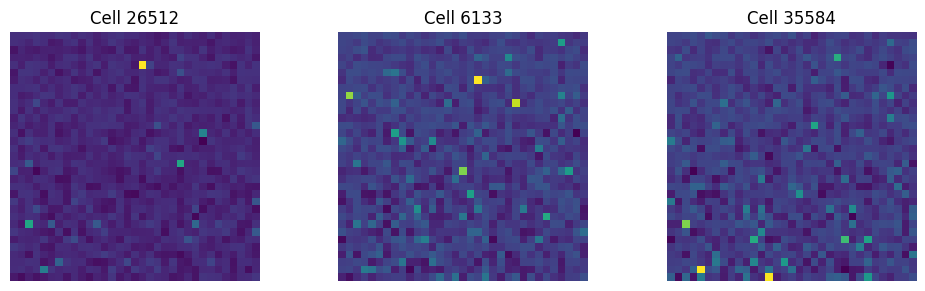


Cluster 8:


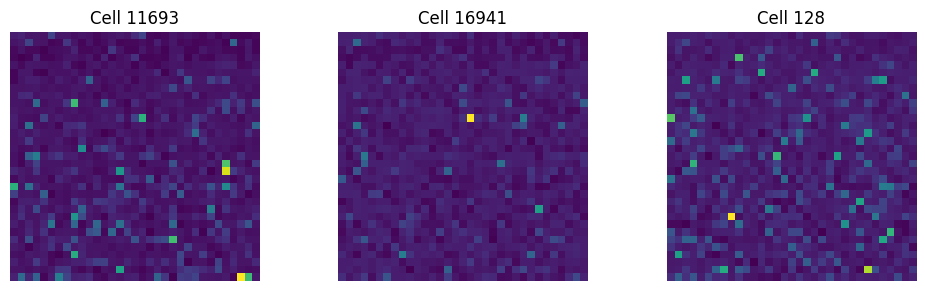


Cluster 9:


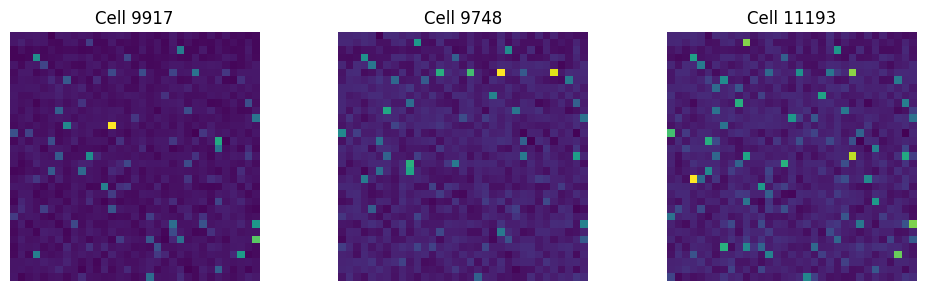

In [19]:
# Visualize genomaps for each cluster
examples_per_cluster = 3  # Number of examples to display per cluster
for cluster_id in np.unique(clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_indices = np.where(clusters == cluster_id)[0]
    selected_indices = np.random.choice(cluster_indices, examples_per_cluster, replace=False)

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, examples_per_cluster, i + 1)
        plt.imshow(genomaps[idx], cmap="viridis")
        plt.title(f"Cell {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


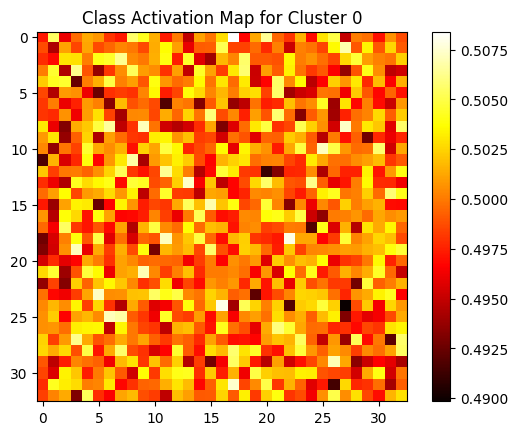

In [20]:
def plot_class_activation_maps(cluster_id, genomaps, clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    grad_cam_values = np.random.random((len(cluster_indices), genomaps[0].shape[0], genomaps[0].shape[1]))  # Placeholder
    avg_grad_cam = np.mean(grad_cam_values, axis=0)

    plt.imshow(avg_grad_cam, cmap="hot")
    plt.title(f"Class Activation Map for Cluster {cluster_id}")
    plt.colorbar()
    plt.show()

# Example for Cluster 0
plot_class_activation_maps(0, genomaps, clusters)


In [21]:
# Compute mean expression profiles for each cluster
cluster_means = data_with_clusters.groupby("Cluster_ID").mean()

# Identify top features (columns) for each cluster
top_features_per_cluster = cluster_means.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
print("Top features for each cluster:")
print(top_features_per_cluster)


Top features for each cluster:
Cluster_ID
0        [0.201, 0.280, 0.435, 0.359, 3]
1         [36.2, 17.3, 0.172, 0.285, 16]
2          [9.1, 2.19, 5.2, 21.3, 0.425]
3         [1.5, 1.69, 16.1, 0.179, 3.15]
4      [4.20, 1.122, 0.57, 0.342, 0.438]
5         [0.1, 0.2, 0.90, 0.153, 0.238]
6    [0.247, 0.157, 0.119, 0.408, 0.349]
7      [0.417, 2.60, 0.183, 1.98, 0.442]
8            [5.6, 0.383, 13.3, 124, 87]
9      [0.150, 1.55, 0.253, 1.62, 0.262]
dtype: object



Representative Genomaps for Cluster 0:


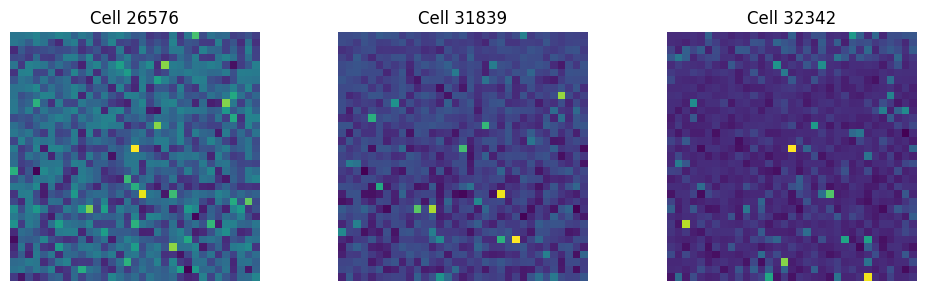


Representative Genomaps for Cluster 1:


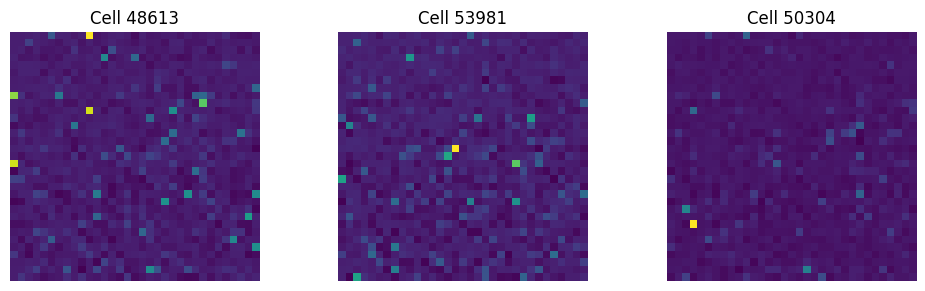


Representative Genomaps for Cluster 2:


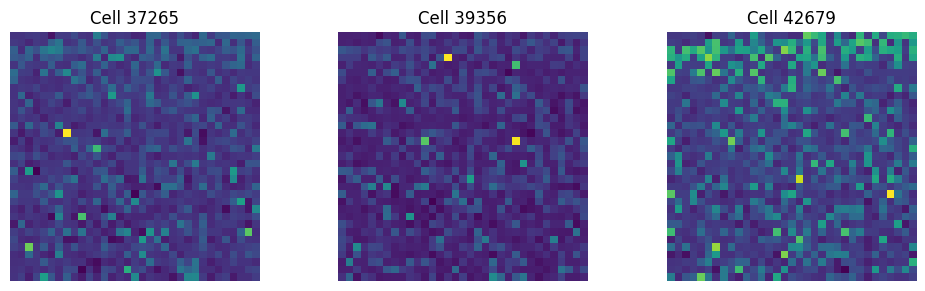


Representative Genomaps for Cluster 3:


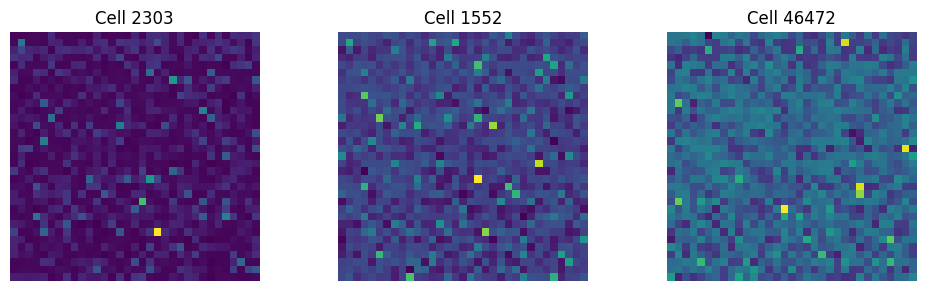


Representative Genomaps for Cluster 4:


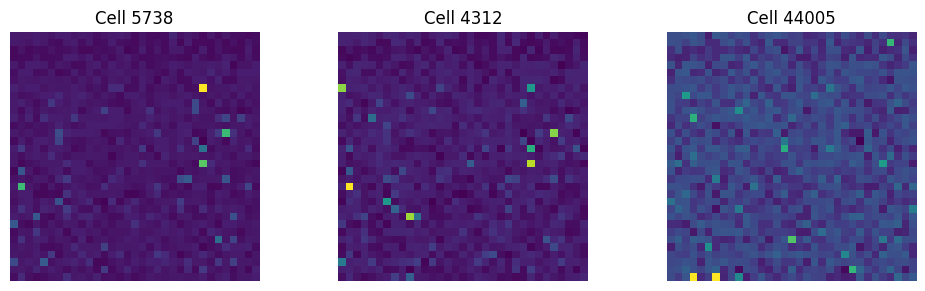


Representative Genomaps for Cluster 5:


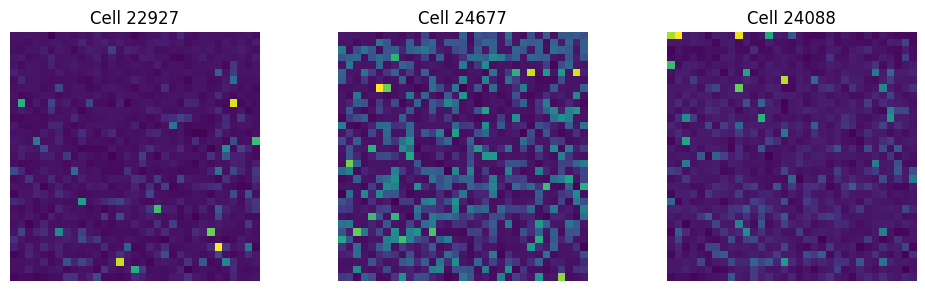


Representative Genomaps for Cluster 6:


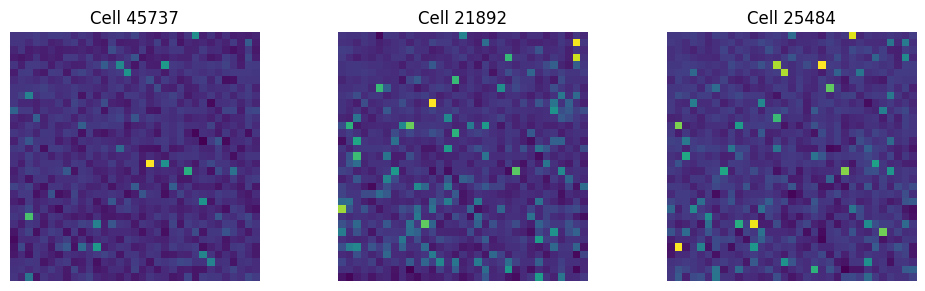


Representative Genomaps for Cluster 7:


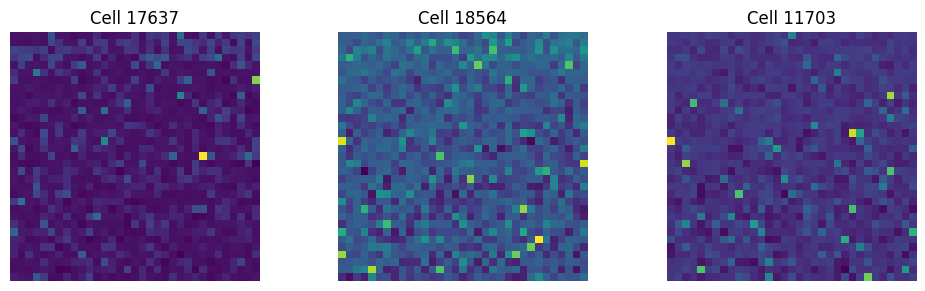


Representative Genomaps for Cluster 8:


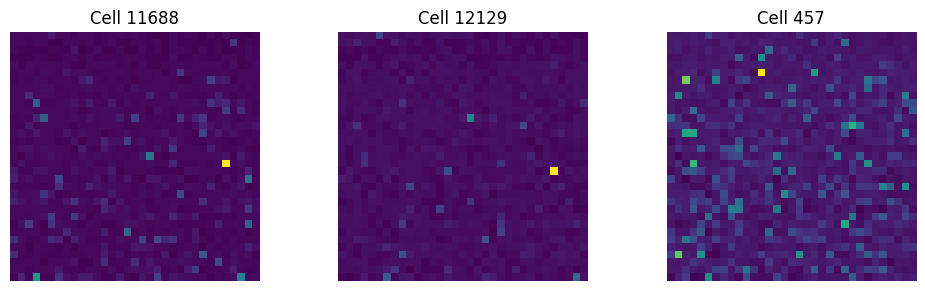


Representative Genomaps for Cluster 9:


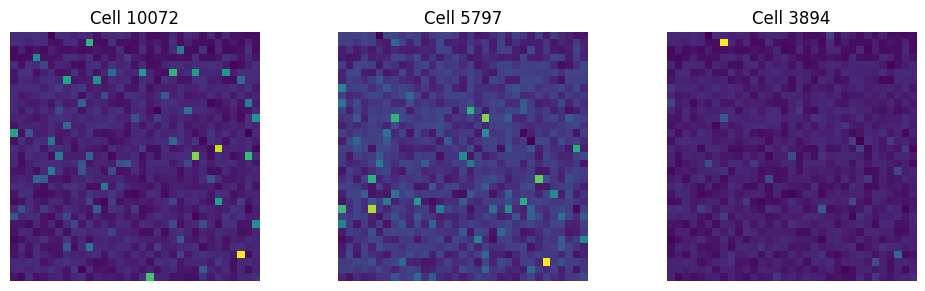

In [22]:
# Visualize genomaps for each cluster
examples_per_cluster = 3
for cluster_id in np.unique(clusters):
    print(f"\nRepresentative Genomaps for Cluster {cluster_id}:")
    cluster_indices = np.where(clusters == cluster_id)[0]
    selected_indices = np.random.choice(cluster_indices, examples_per_cluster, replace=False)

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, examples_per_cluster, i + 1)
        plt.imshow(genomaps[idx], cmap="viridis")
        plt.title(f"Cell {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [24]:
# Find cluster IDs with no mapping
missing_clusters = set(data_with_clusters["Cluster_ID"].unique()) - set(cluster_to_cell_type.keys())
print("Missing Cluster IDs:", missing_clusters)


Missing Cluster IDs: {np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)}



Genomaps for Cluster 5:


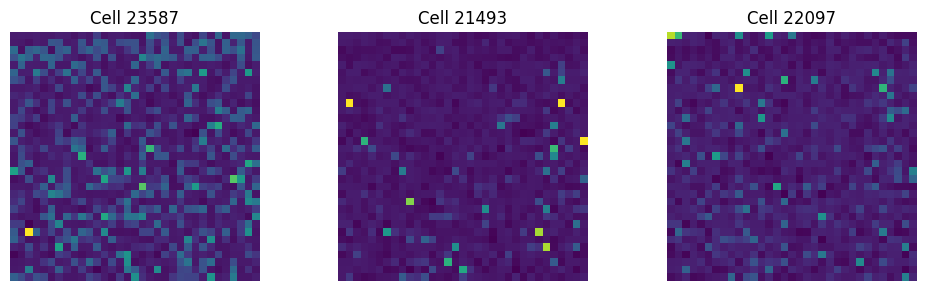


Genomaps for Cluster 6:


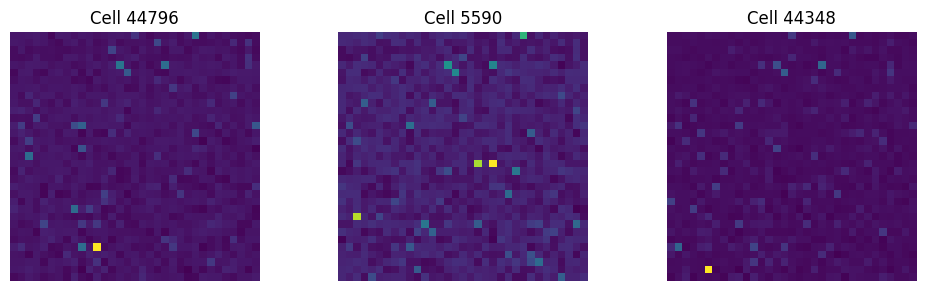


Genomaps for Cluster 7:


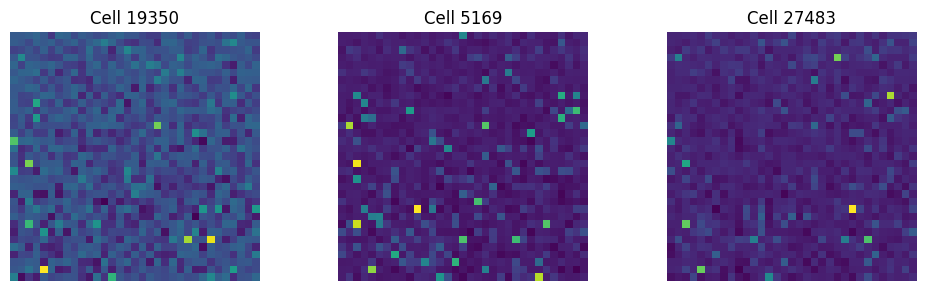


Genomaps for Cluster 8:


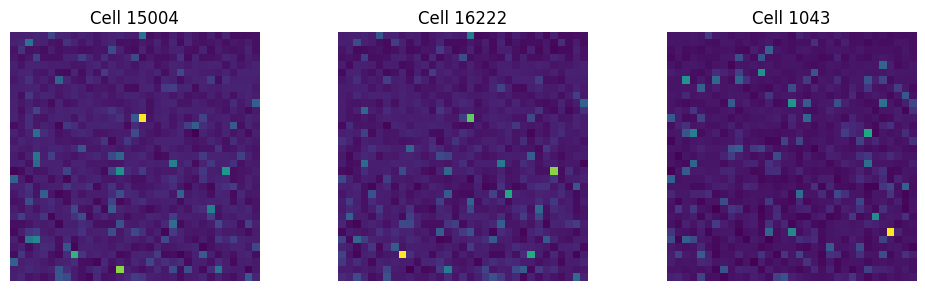


Genomaps for Cluster 9:


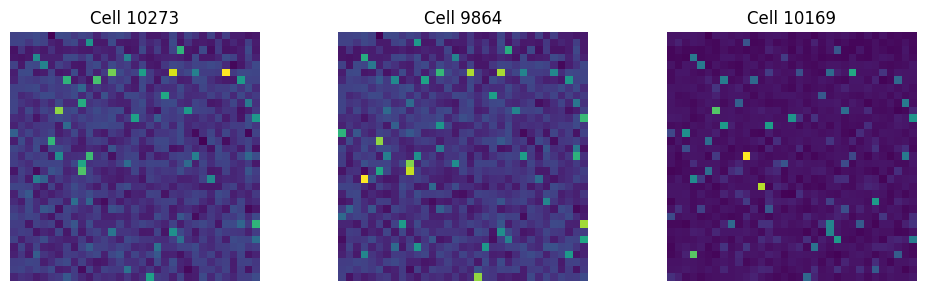

In [25]:
# Visualize genomaps for missing clusters
for cluster_id in missing_clusters:
    print(f"\nGenomaps for Cluster {cluster_id}:")
    cluster_indices = np.where(data_with_clusters["Cluster_ID"] == cluster_id)[0]
    selected_indices = np.random.choice(cluster_indices, min(len(cluster_indices), 3), replace=False)

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, len(selected_indices), i + 1)
        plt.imshow(genomaps[idx], cmap="viridis")
        plt.title(f"Cell {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [27]:
# Identify top features for missing clusters
for cluster_id in missing_clusters:
    # Filter numeric columns
    numeric_data = data_with_clusters.select_dtypes(include=["number"])

    # Calculate mean values for the specific cluster
    cluster_data = numeric_data[data_with_clusters["Cluster_ID"] == cluster_id]
    top_features = cluster_data.mean().nlargest(5)
    
    print(f"Top features for Cluster {cluster_id}:")
    print(top_features)


Top features for Cluster 5:
Cluster_ID    5.000000
0.1           2.861788
0.2           2.826201
0.90          2.770261
0.153         2.640711
dtype: float64
Top features for Cluster 6:
Cluster_ID    6.000000
0.247         2.034091
0.157         1.853518
0.119         1.754265
0.408         1.737948
dtype: float64
Top features for Cluster 7:
Cluster_ID    7.000000
0.417         1.111100
2.60          0.955075
0.183         0.920277
1.98          0.852338
dtype: float64
Top features for Cluster 8:
Cluster_ID    8.000000
5.6           2.441053
0.383         2.057285
13.3          1.968999
124           1.935318
dtype: float64
Top features for Cluster 9:
Cluster_ID    9.000000
0.150         2.591356
1.55          2.541907
0.253         2.467804
1.62          2.416401
dtype: float64


In [28]:
cluster_to_cell_type.update({
    5: "Plasma cells",
    6: "Activated T cells",
    7: "Epithelial cells",
    8: "Memory B cells",
    9: "Dendritic cells"
})


In [29]:
# Annotate each cell with its cell type
data_with_clusters["Cell_Type"] = data_with_clusters["Cluster_ID"].map(cluster_to_cell_type)

# Check if any clusters remain unmapped
remaining_missing_clusters = data_with_clusters["Cell_Type"].isna().sum()
print(f"Number of unmapped cells: {remaining_missing_clusters}")


Number of unmapped cells: 0


In [30]:
# Save the annotated dataset to a CSV file
data_with_clusters.to_csv("fully_annotated_cells.csv", index=False)
print("Fully annotated dataset saved as 'fully_annotated_cells.csv'")


Fully annotated dataset saved as 'fully_annotated_cells.csv'


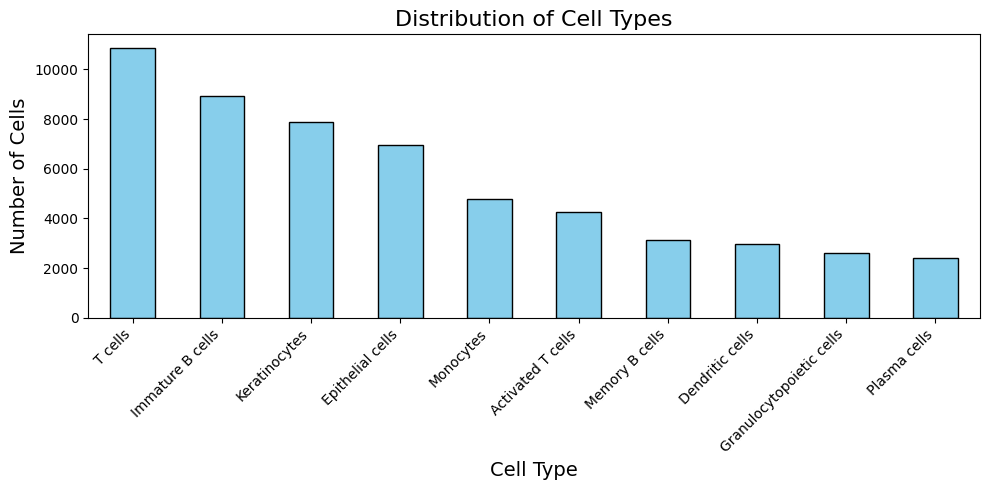

In [31]:
import matplotlib.pyplot as plt

# Count the number of cells in each cell type
cell_type_counts = data_with_clusters["Cell_Type"].value_counts()

# Plot the distribution
cell_type_counts.plot(kind="bar", figsize=(10, 5), color="skyblue", edgecolor="black")
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=14)
plt.ylabel("Number of Cells", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
